# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [24]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [25]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


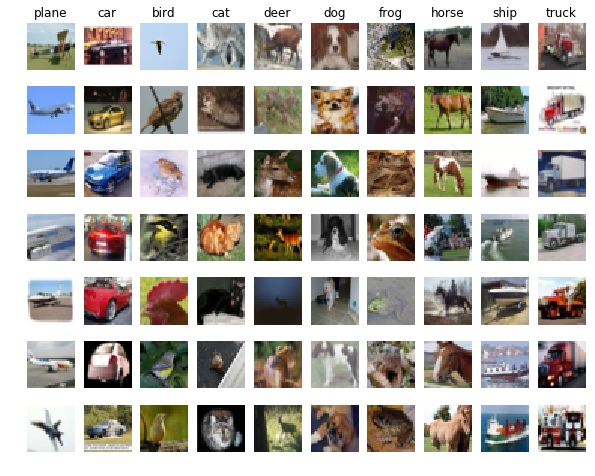

In [26]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [27]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [28]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


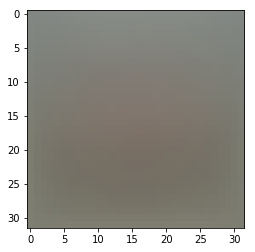

In [29]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [30]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [32]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [35]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.990816


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [39]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 31.770426 analytic: 31.770426, relative error: 5.170096e-12
numerical: 34.663507 analytic: 34.663507, relative error: 9.123380e-12
numerical: -1.259352 analytic: -1.259352, relative error: 1.822317e-10
numerical: 41.341122 analytic: 41.341122, relative error: 9.450271e-12
numerical: 9.495884 analytic: 9.495884, relative error: 1.037412e-11
numerical: 21.127948 analytic: 21.127948, relative error: 7.328835e-12
numerical: 3.848333 analytic: 3.848333, relative error: 4.246120e-11
numerical: 26.138642 analytic: 26.138642, relative error: 2.238638e-12
numerical: 5.910108 analytic: 5.910108, relative error: 4.176617e-11
numerical: -12.729732 analytic: -12.729732, relative error: 4.234042e-12
numerical: 2.444223 analytic: 2.444223, relative error: 4.528870e-11
numerical: 11.624380 analytic: 11.624380, relative error: 2.060737e-11
numerical: 2.670004 analytic: 2.670004, relative error: 1.058676e-10
numerical: -35.123689 analytic: -35.123689, relative error: 4.996844e-12
numerical: -

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [213]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 1e4)#0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 1e4)#0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 1.203604e+01 computed in 0.079811s
Vectorized loss: 1.203604e+01 computed in 0.007553s
difference: 0.000000


In [210]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.069224s
Vectorized loss and gradient: computed in 0.007812s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [108]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 24.851382
iteration 100 / 1500: loss 7.695344
iteration 200 / 1500: loss 5.813706
iteration 300 / 1500: loss 5.786286
iteration 400 / 1500: loss 5.310041
iteration 500 / 1500: loss 4.847554
iteration 600 / 1500: loss 5.115811
iteration 700 / 1500: loss 4.571826
iteration 800 / 1500: loss 4.858310
iteration 900 / 1500: loss 4.923943
iteration 1000 / 1500: loss 5.036601
iteration 1100 / 1500: loss 5.005264
iteration 1200 / 1500: loss 5.027465
iteration 1300 / 1500: loss 4.473787
iteration 1400 / 1500: loss 4.411155
That took 5.834241s


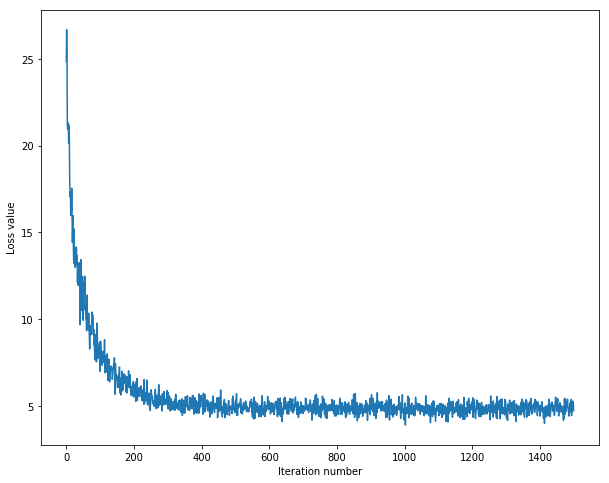

In [109]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [126]:
a=np.array([[1,2],[3,4]])
b=np.random.choice(2,2,replace=False)
# print (y_val)

In [128]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.365612
validation accuracy: 0.377000


In [206]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
num_tuning = 5
learning_rates_ = np.linspace(np.log(learning_rates)[0], np.log(learning_rates)[1], num_tuning)
regularization_strengths_ = np.linspace(np.log(regularization_strengths)[0], np.log(regularization_strengths)[1], num_tuning)

for i in xrange(num_tuning): #learning_rate
    for j in xrange(num_tuning): #reg_strength
        svm = LinearSVM()
        print (np.exp(learning_rates_[i]), np.exp(regularization_strengths_[j]))
        loss_hist = svm.train(X_train, y_train, learning_rate=np.exp(learning_rates_[i]), reg=np.exp(regularization_strengths_[j]),
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        y_val_accuracy = np.mean(y_val == y_val_pred)
#         print ('accuracies = ', y_train_accuracy, y_val_accuracy)
#         results[i] = np.exp(learning_rates_[i])
#         results[j] = np.exp(regularization_strengths_[j])
        results[(np.exp(learning_rates_[i]),np.exp(regularization_strengths_[j]))]=[y_train_accuracy,y_val_accuracy]
        if (y_val_accuracy>best_val):
            best_val = y_val_accuracy
            best_svm = svm
            
      
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-07 25000.0
iteration 0 / 1500: loss 27.824396
iteration 100 / 1500: loss 7.231549
iteration 200 / 1500: loss 6.045741
iteration 300 / 1500: loss 5.263542
iteration 400 / 1500: loss 5.089967
iteration 500 / 1500: loss 4.826570
iteration 600 / 1500: loss 4.698801
iteration 700 / 1500: loss 4.689298
iteration 800 / 1500: loss 4.631924
iteration 900 / 1500: loss 4.810397
iteration 1000 / 1500: loss 4.616674
iteration 1100 / 1500: loss 4.350829
iteration 1200 / 1500: loss 4.876872
iteration 1300 / 1500: loss 5.414316
iteration 1400 / 1500: loss 4.565555
1e-07 27001.4934723
iteration 0 / 1500: loss 19.494913
iteration 100 / 1500: loss 8.025687
iteration 200 / 1500: loss 5.779847
iteration 300 / 1500: loss 5.011182
iteration 400 / 1500: loss 5.147416
iteration 500 / 1500: loss 4.638343
iteration 600 / 1500: loss 4.620997
iteration 700 / 1500: loss 5.017583
iteration 800 / 1500: loss 5.034899
iteration 900 / 1500: loss 5.027816
iteration 1000 / 1500: loss 5.034872
iteration 1100 / 1500: los

iteration 700 / 1500: loss 5.382502
iteration 800 / 1500: loss 5.278945
iteration 900 / 1500: loss 4.950556
iteration 1000 / 1500: loss 5.294275
iteration 1100 / 1500: loss 5.124250
iteration 1200 / 1500: loss 5.518492
iteration 1300 / 1500: loss 5.292432
iteration 1400 / 1500: loss 4.770616
1.99473659878e-07 36743.3623069
iteration 0 / 1500: loss 19.129513
iteration 100 / 1500: loss 5.235859
iteration 200 / 1500: loss 5.537478
iteration 300 / 1500: loss 5.502203
iteration 400 / 1500: loss 5.380496
iteration 500 / 1500: loss 4.600814
iteration 600 / 1500: loss 4.873907
iteration 700 / 1500: loss 5.051520
iteration 800 / 1500: loss 4.713301
iteration 900 / 1500: loss 4.552300
iteration 1000 / 1500: loss 4.836070
iteration 1100 / 1500: loss 4.874282
iteration 1200 / 1500: loss 4.968173
iteration 1300 / 1500: loss 4.933052
iteration 1400 / 1500: loss 4.413809
1.99473659878e-07 39685.0262992
iteration 0 / 1500: loss 19.326251
iteration 100 / 1500: loss 5.126681
iteration 200 / 1500: loss 4

iteration 1100 / 1500: loss 5.703506
iteration 1200 / 1500: loss 5.194117
iteration 1300 / 1500: loss 5.560035
iteration 1400 / 1500: loss 5.435796
3.97897409849e-07 50000.0
iteration 0 / 1500: loss 24.221150
iteration 100 / 1500: loss 6.038478
iteration 200 / 1500: loss 5.296547
iteration 300 / 1500: loss 5.343562
iteration 400 / 1500: loss 5.567168
iteration 500 / 1500: loss 5.525276
iteration 600 / 1500: loss 5.395225
iteration 700 / 1500: loss 4.947872
iteration 800 / 1500: loss 5.527529
iteration 900 / 1500: loss 5.408739
iteration 1000 / 1500: loss 4.869804
iteration 1100 / 1500: loss 5.637808
iteration 1200 / 1500: loss 5.339241
iteration 1300 / 1500: loss 4.889936
iteration 1400 / 1500: loss 5.467621
7.93700525984e-07 25000.0
iteration 0 / 1500: loss 18.607969
iteration 100 / 1500: loss 6.259848
iteration 200 / 1500: loss 5.800677
iteration 300 / 1500: loss 5.565999
iteration 400 / 1500: loss 5.930389
iteration 500 / 1500: loss 5.548626
iteration 600 / 1500: loss 5.682275
itera

iteration 100 / 1500: loss 7.644693
iteration 200 / 1500: loss 7.181261
iteration 300 / 1500: loss 8.793883
iteration 400 / 1500: loss 9.381102
iteration 500 / 1500: loss 7.348045
iteration 600 / 1500: loss 6.255212
iteration 700 / 1500: loss 5.948823
iteration 800 / 1500: loss 7.467684
iteration 900 / 1500: loss 7.664896
iteration 1000 / 1500: loss 7.655954
iteration 1100 / 1500: loss 6.702215
iteration 1200 / 1500: loss 6.880228
iteration 1300 / 1500: loss 6.570416
iteration 1400 / 1500: loss 6.810596
1.58322348765e-06 34019.7500044
iteration 0 / 1500: loss 20.675184
iteration 100 / 1500: loss 6.737645
iteration 200 / 1500: loss 8.328674
iteration 300 / 1500: loss 7.997338
iteration 400 / 1500: loss 8.108348
iteration 500 / 1500: loss 8.272158
iteration 600 / 1500: loss 10.146631
iteration 700 / 1500: loss 10.106838
iteration 800 / 1500: loss 8.059106
iteration 900 / 1500: loss 6.835948
iteration 1000 / 1500: loss 6.899562
iteration 1100 / 1500: loss 8.380339
iteration 1200 / 1500: l

iteration 300 / 1500: loss 12.951982
iteration 400 / 1500: loss 10.797199
iteration 500 / 1500: loss 15.204890
iteration 600 / 1500: loss 12.048504
iteration 700 / 1500: loss 10.967180
iteration 800 / 1500: loss 11.460307
iteration 900 / 1500: loss 13.997345
iteration 1000 / 1500: loss 10.881373
iteration 1100 / 1500: loss 10.030098
iteration 1200 / 1500: loss 14.119171
iteration 1300 / 1500: loss 12.171690
iteration 1400 / 1500: loss 11.595657
3.15811383485e-06 46293.7356144
iteration 0 / 1500: loss 24.521708
iteration 100 / 1500: loss 12.263292
iteration 200 / 1500: loss 10.001391
iteration 300 / 1500: loss 16.677723
iteration 400 / 1500: loss 18.159688
iteration 500 / 1500: loss 15.979551
iteration 600 / 1500: loss 14.949498
iteration 700 / 1500: loss 12.247601
iteration 800 / 1500: loss 13.806710
iteration 900 / 1500: loss 16.412706
iteration 1000 / 1500: loss 18.996871
iteration 1100 / 1500: loss 12.230618
iteration 1200 / 1500: loss 14.833585
iteration 1300 / 1500: loss 12.859421

iteration 200 / 1500: loss 59.172974
iteration 300 / 1500: loss 61.535645
iteration 400 / 1500: loss 69.055426
iteration 500 / 1500: loss 66.945818
iteration 600 / 1500: loss 58.709189
iteration 700 / 1500: loss 80.365636
iteration 800 / 1500: loss 66.244121
iteration 900 / 1500: loss 48.786061
iteration 1000 / 1500: loss 74.630850
iteration 1100 / 1500: loss 55.265022
iteration 1200 / 1500: loss 72.735079
iteration 1300 / 1500: loss 62.440790
iteration 1400 / 1500: loss 65.196930
1.2566053149e-05 29163.2259894
iteration 0 / 1500: loss 18.752009
iteration 100 / 1500: loss 55.178707
iteration 200 / 1500: loss 65.819690
iteration 300 / 1500: loss 65.682389
iteration 400 / 1500: loss 70.070749
iteration 500 / 1500: loss 60.368402
iteration 600 / 1500: loss 83.942246
iteration 700 / 1500: loss 52.707419
iteration 800 / 1500: loss 102.522933
iteration 900 / 1500: loss 69.485523
iteration 1000 / 1500: loss 75.353003
iteration 1100 / 1500: loss 51.766945
iteration 1200 / 1500: loss 54.217225


iteration 1400 / 1500: loss 665.920372
2.50659661184e-05 36743.3623069
iteration 0 / 1500: loss 19.321397
iteration 100 / 1500: loss 1639.252606
iteration 200 / 1500: loss 1653.236279
iteration 300 / 1500: loss 1540.659032
iteration 400 / 1500: loss 1812.670138
iteration 500 / 1500: loss 1657.236612
iteration 600 / 1500: loss 1537.169543
iteration 700 / 1500: loss 1555.167154
iteration 800 / 1500: loss 2181.472054
iteration 900 / 1500: loss 1625.113463
iteration 1000 / 1500: loss 1767.101260
iteration 1100 / 1500: loss 1671.922827
iteration 1200 / 1500: loss 1825.212708
iteration 1300 / 1500: loss 1675.380601
iteration 1400 / 1500: loss 1524.208130
2.50659661184e-05 39685.0262992
iteration 0 / 1500: loss 23.760837
iteration 100 / 1500: loss 14383.911433
iteration 200 / 1500: loss 23985.879925
iteration 300 / 1500: loss 18475.318662
iteration 400 / 1500: loss 23662.734329
iteration 500 / 1500: loss 25103.542538
iteration 600 / 1500: loss 22594.936092
iteration 700 / 1500: loss 23180.714

iteration 1100 / 1500: loss 51195159589786895745186065251110910648557773738879940780846761448484659938987805774165714366362162780275910984936417206725592392358341443111517762863191419128086518801636860366573965949374337908736.000000
iteration 1200 / 1500: loss 23351538579936446960919613856619169077068989575529984680091017807599675037072162828448917363581648189710141860842508294642863507310678215356248446712000045972025116222579890614392823587462129825713978033772561432576.000000
iteration 1300 / 1500: loss 8125155338444221200501741254440272490093386742767403850629474790887310009146612208326894739566523464644005162945526739041672115847959721854064527618875068562939587760515224582268082004045033045977419089728397389245851781010129158144.000000
iteration 1400 / 1500: loss 3254896480780086254284006331515639599635529952219522404379828240200554911573145962645591676299579925164641172609180622082387940574410670144821319132970041791748939693685606567459801868214356177555833079210185994141659055

cs231n/classifiers/linear_classifier.py:70: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate*grad


iteration 1400 / 1500: loss nan
5e-05 29163.2259894
iteration 0 / 1500: loss 22.962010
iteration 100 / 1500: loss 10169506615194780834080049070080.000000
iteration 200 / 1500: loss 198060900124392884018088351480890210885652285422551686971392.000000
iteration 300 / 1500: loss 2405301694952077600689072307898039537215092937486050840873960723385462210808179652034560.000000
iteration 400 / 1500: loss 48245870242072686027937058700990439783197807393877961839012218059290957984655105780867002589557627172470921447342080.000000
iteration 500 / 1500: loss 903782585674496519242694163435237527504845866188627278747961380078511795059635941527806243109381740819919961203864743354029903168770011297742848.000000
iteration 600 / 1500: loss 15813315763966910504274801504558539550194312140755103705294889671740542429390463275767585812599946944577013010840008998258860807730444897311144692048378391725354715575222272.000000
iteration 700 / 1500: loss 291511014080837019675997285831022721362879866298211534770344600

iteration 500 / 1500: loss 36302088445538583185098978980443887062898234228872495993232439587913748824692035292651886000403637318779451444399948188872178182278012220538599048324513316764610546094083855664797096532581469770590987140596042236227423980260179078094520320.000000
iteration 600 / 1500: loss 6073299784307953963597313668829364113326767886081627322171989413787823408880880138992358422408479442390005974088804028219919483704472452920683887905613074523877719425895328284342446499063060202946032614904462130440089413938295014399849214836571931578371568382941806726071090373336236032.000000
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
5e-05 42862.1991427
iteration 0 / 1500: loss 22.286104
iteration 100 / 1500: loss 1068291524576684885360542586214903848616643015034798080.000000
iterati

lr 3.158114e-06 reg 3.401975e+04 train accuracy: 0.177714 val accuracy: 0.179000
lr 3.158114e-06 reg 3.674336e+04 train accuracy: 0.195327 val accuracy: 0.182000
lr 3.158114e-06 reg 3.968503e+04 train accuracy: 0.169694 val accuracy: 0.173000
lr 3.158114e-06 reg 4.286220e+04 train accuracy: 0.190653 val accuracy: 0.205000
lr 3.158114e-06 reg 4.629374e+04 train accuracy: 0.223143 val accuracy: 0.223000
lr 3.158114e-06 reg 5.000000e+04 train accuracy: 0.181020 val accuracy: 0.181000
lr 6.299605e-06 reg 2.500000e+04 train accuracy: 0.193306 val accuracy: 0.204000
lr 6.299605e-06 reg 2.700149e+04 train accuracy: 0.154245 val accuracy: 0.152000
lr 6.299605e-06 reg 2.916323e+04 train accuracy: 0.175633 val accuracy: 0.182000
lr 6.299605e-06 reg 3.149803e+04 train accuracy: 0.176816 val accuracy: 0.180000
lr 6.299605e-06 reg 3.401975e+04 train accuracy: 0.212837 val accuracy: 0.211000
lr 6.299605e-06 reg 3.674336e+04 train accuracy: 0.196755 val accuracy: 0.212000
lr 6.299605e-06 reg 3.968503

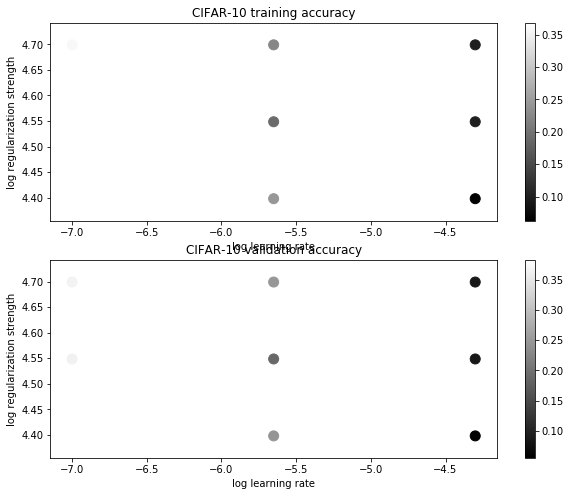

In [203]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [204]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.361000


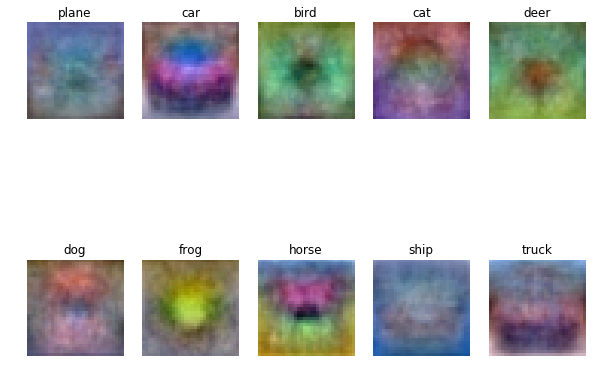

In [205]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*